# Demo - Conditional Gaussianization Flow (Classification)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [4]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, label_binarize

# %%wandb
# get data
seed = 123
n_samples = 5_000
noise = 0.05


def f(n_samples: int = 5_000, noise: float = 0.05, seed: int = 123):
    X, Y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    #     X, Y = datasets.make_circles(
    #         n_samples=n_samples, noise=noise, random_state=seed, factor=0.5
    #     )
    return X, Y[:, None]


X, Y = f(n_samples, noise, seed)
Y_labels = label_binarize(Y, classes=np.unique(Y))

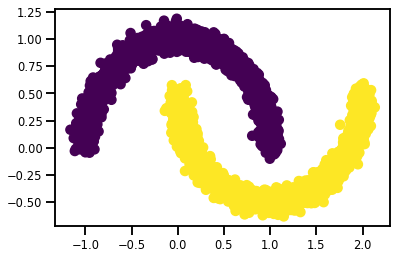

In [5]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

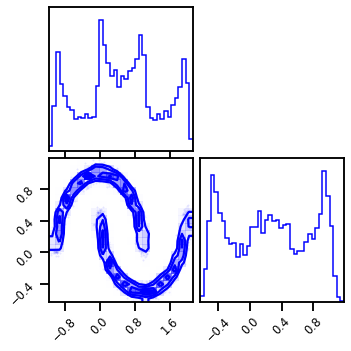

In [33]:
# plot data
fig = corner.corner(X, color="blue", hist_bin_factor=2)
fig.savefig("cde_data")

## DataLoader

In [8]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array
Batch = Array


def prepare_data(batch: Batch, rng=None) -> Array:
    inputs, labels = batch

    # select image from tfds
    inputs = inputs.astype(jnp.float32)
    labels = labels.astype(jnp.float32)

    return inputs, labels

## Model

In [9]:
from rbig_jax.models.gaussflow import init_default_gf_model


# marginal uniformization
mixture = "gaussian"
n_components = 10
init_mixcdf = "gmm"

# inverse cdf
inverse_cdf = "gaussian"

# rotation transformation
n_reflections = 2
init_rotation = "random"

# nn params
n_blocks = 8

In [10]:
# init model
gf_model = init_default_gf_model(
    shape=X.shape[1:],
    X=X,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
)

Initializing - Block: 8 | Layer 23: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


### Plot Initial Layers

In [11]:
%%time

# X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

gf_model.score(X)

CPU times: user 1.64 s, sys: 136 ms, total: 1.78 s
Wall time: 1.44 s


DeviceArray(1.5749104, dtype=float32)

### Conditional Model

In [12]:
from distrax._src.distributions.log_stddev_normal import LogStddevNormal
from typing import Sequence, Callable, Tuple
import flax
from flax import linen as nn
from flax import struct


class ExplicitMLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        # we automatically know what to do with lists, dicts of submodules
        self.layers = [nn.Dense(feat) for feat in self.features]
        # for single submodules, we would just write:
        # self.layer1 = nn.Dense(self, feat1)

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        return x

In [13]:
from rbig_jax.models.conditional import ExplicitMLP

# create model
input_features = X.shape[1]
# model = nn.Dense(features=input_features * 2)
model = ExplicitMLP(features=[16, input_features * 2])
# create dummy variable
rng, model_rng = jax.random.split(KEY, 2)
params = model.init(model_rng, Y)

output = model.apply(params, Y)
Y.shape, output.shape

((5000, 1), (5000, 4))

In [14]:
from rbig_jax.models.conditional import ConditionalModel

In [15]:
encoder = ConditionalModel(params=params, model=model)

In [16]:
from rbig_jax.models.conditional import ConditionalGaussianizationFlow
from distrax._src.distributions.normal import Normal

cgf_model = ConditionalGaussianizationFlow(
    bijectors=gf_model.bijectors, base_dist=Normal, encoder=encoder
)

### Data Loader

#### Prepare Data

In [17]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch, rng=None) -> Array:
    inputs, labels = batch

    # select image from tfds
    inputs = inputs.astype(jnp.float32)
    labels = labels.astype(jnp.float32)

    return inputs, labels

In [18]:
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.preprocessing import label_binarize, LabelBinarizer, MultiLabelBinarizer
from sklearn import datasets
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(
    n_train: int,
    batch_size: int,
    seed: int,
    n_samples: int = 2_000,
    noise: float = 0.05,
) -> Iterator[Batch]:
    X, y = f(n_samples=n_train, noise=noise, seed=seed)

    if y.ndim < 2:
        y = label_binarize(y, classes=np.unique(y))
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

### Optimizer

In [19]:
from rbig_jax.training.parametric import init_optimizer

In [20]:
n_epochs = 5_000
# initialize optimizer
optimizer = init_optimizer(
    "adam", lr=1e-3, cosine_decay_steps=n_epochs, gradient_norm_clip=1.0, alpha=1e-1,
)

### Trainer

In [21]:
from rbig_jax.training.parametric import ConditionalGaussFlowTrainer

# initial flow trainer
cnf_trainer = ConditionalGaussFlowTrainer(
    cgf_model, optimizer, n_epochs=n_epochs, prepare_data_fn=prepare_data,
)

In [22]:
cgf_model.score(X, Y_labels)

DeviceArray(2.2175307, dtype=float32)

In [23]:
train_ds = load_dataset(5_000, 256, 123)
valid_ds = load_dataset(1_000, 1_000, 42)

eval_loss = 0.0
eval_frequency = 50
with tqdm.trange(n_epochs) as pbar:
    for step in pbar:

        # Train Step
        output = cnf_trainer.train_step(next(train_ds))
        train_loss = output.loss
        pbar.set_description(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
        )

        # Eval Step
        if step % eval_frequency == 0:
            output = cnf_trainer.validation_step(next(valid_ds))
            eval_loss = output.loss
            pbar.set_description(
                f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )

cgf_model = output.model

Train Loss: -0.2752 | Valid Loss: -0.2247: 100%|██████████| 5000/5000 [02:20<00:00, 35.67it/s] 


### Results

#### Losses

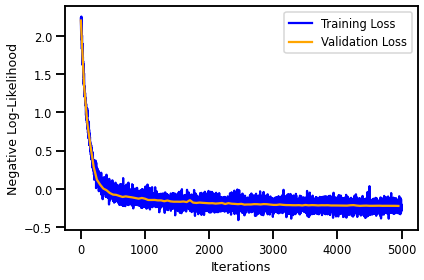

In [24]:
fig, ax = plt.subplots()
ax.plot(
    cnf_trainer.train_epoch, cnf_trainer.train_loss, label="Training Loss", color="blue"
)
ax.plot(
    cnf_trainer.valid_epoch,
    cnf_trainer.valid_loss,
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Inverse Transform

### Log Probability

#### Plot: Original Density

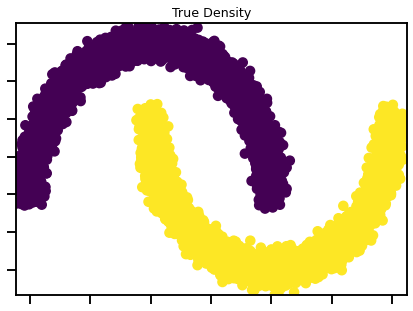

In [25]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 10_000
noise = 0.05
seed = 123
# X_plot, y_plot = datasets.make_moons(
#     n_samples=n_samples, noise=noise, random_state=seed
# )
X_plot, y_plot = f(n_samples=n_samples, seed=seed)


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.scatter(
    X_plot[:, 0],
    X_plot[:, 1],
    c=y_plot,  # bins=512, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [26]:
jnp.array([0]).reshape(-1, 1).shape

(1, 1)

In [27]:
%%time

n_grid = 500
buffer = 0.01
xline = jnp.linspace(X[:, 0].min() - buffer, X[:, 0].max() + buffer, n_grid)
yline = jnp.linspace(X[:, 1].min() - buffer, X[:, 1].max() + buffer, n_grid)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

# calculate log probability
X_log_prob_z1 = cgf_model.score_samples(xyinput, jnp.array([0]).reshape(-1, 1))
X_log_prob_z2 = cgf_model.score_samples(xyinput, jnp.array([1]).reshape(-1, 1))

CPU times: user 21.7 s, sys: 3.9 s, total: 25.6 s
Wall time: 7.91 s


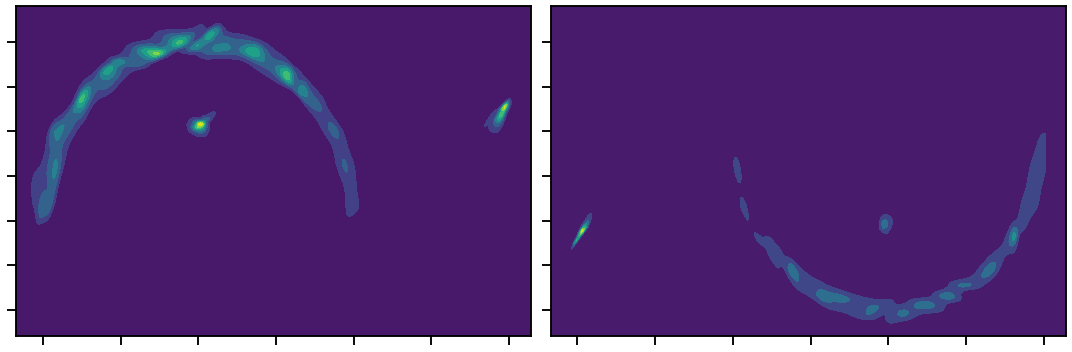

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].contourf(xgrid, ygrid, np.exp(X_log_prob_z1).reshape(n_grid, n_grid))
ax[1].contourf(xgrid, ygrid, np.exp(X_log_prob_z2).reshape(n_grid, n_grid))
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[0].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.tight_layout()
plt.show()

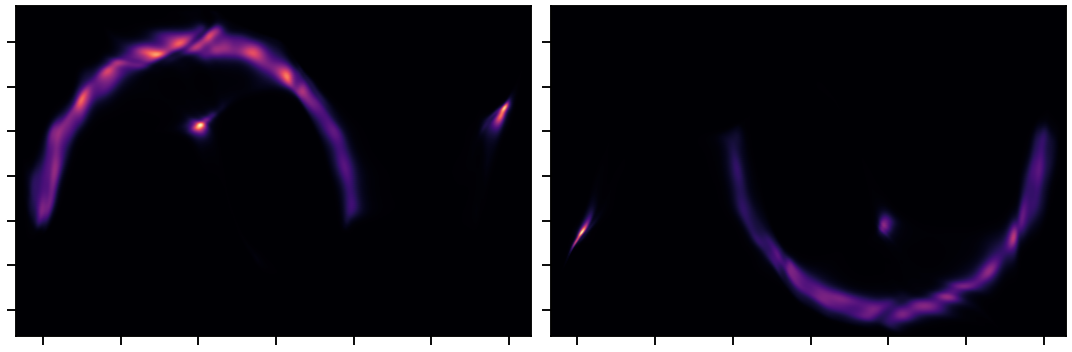

In [29]:
cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

h1 = ax[0].scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=np.exp(X_log_prob_z1),
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
h1 = ax[1].scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=np.exp(X_log_prob_z2),
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)

ax[0].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.savefig("demo_cde")
plt.show()

## Sampling

In [30]:
%%time

n_gen_samples = 10_000

X1_samples = cgf_model.sample(outputs=jnp.zeros(1)[:, None], seed=123, n_samples=n_gen_samples)
X2_samples = cgf_model.sample(outputs=jnp.ones(1)[:, None], seed=123, n_samples=n_gen_samples)

CPU times: user 5min 37s, sys: 17.6 s, total: 5min 55s
Wall time: 59.3 s


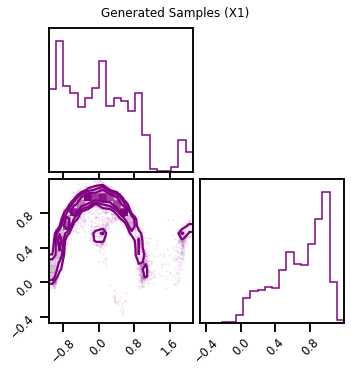

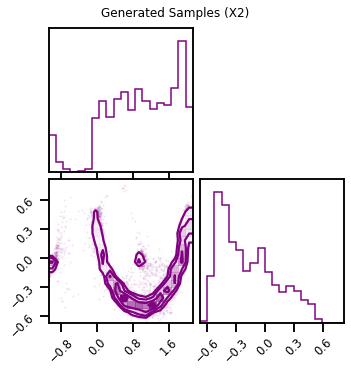

In [32]:
fig2 = corner.corner(np.array(X1_samples), color="purple")
fig2.suptitle("Generated Samples (X1)")
plt.show()
fig2.savefig("cde_samples_x1")

fig2 = corner.corner(np.array(X2_samples), color="purple")
fig2.suptitle("Generated Samples (X2)")
plt.show()
fig2.savefig("cde_samples_x2")

## Saving/Loading Model

#### Save Model

In [ ]:
import joblib

joblib.dump(gf_model, "cgf_model.pickle")

#### Load Model

In [ ]:
rbig_model_loaded = joblib.load("cgf_model.pickle")